In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import git
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [2]:
# Geographic and population centers for each county in US.
county_centers = pd.read_csv(f"{homedir}/data/us/geolocation/county_centers.csv")

In [3]:
county_centers.head()

,fips,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10
0,1001,-86.577176,32.523283,-86.644490,32.536382,-86.501832,32.500323,-86.494165,32.500389
1,1003,-87.748260,30.592781,-87.746067,30.659218,-87.760540,30.565383,-87.762381,30.548923
2,1005,-85.331312,31.856515,-85.405456,31.870670,-85.306746,31.847869,-85.310038,31.844036
3,1007,-87.123243,33.040054,-87.127148,33.015893,-87.127019,33.025947,-87.127659,33.030921
4,1009,-86.554768,33.978461,-86.567246,33.977448,-86.582617,33.962601,-86.591491,33.955243


In [4]:
# Confirmed Cases 
confirmed_cases = pd.read_csv(f"{homedir}/data/us/covid/confirmed_cases.csv")

In [5]:
confirmed_cases[confirmed_cases["State"] == "CA"].sample(5)

,countyFIPS,County Name,State,stateFIPS,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
124,6061,Placer County,CA,6,0,0,0,0,0,0,...,8,8,9,9,9,12,12,20,26,30
122,6057,Nevada County,CA,6,0,0,0,0,0,0,...,1,1,1,1,1,1,1,3,4,4
145,6113,Yolo County,CA,6,0,0,0,0,0,0,...,2,4,5,5,6,6,6,8,10,11
109,6019,Fresno County,CA,6,0,0,0,0,0,0,...,2,2,3,3,6,6,6,13,18,19
114,6037,Los Angeles County,CA,6,0,0,0,0,1,1,...,94,144,190,231,292,351,409,536,662,799


In [6]:
# Join County Centers Table with Confirmed Cases Table
# ft. CS 121
# - https://stackoverflow.com/questions/26645515/pandas-join-issue-columns-overlap-but-no-suffix-specified
combined = county_centers.rename(
    {'fips': 'countyFIPS'}, axis='columns'
    ).join(
        confirmed_cases.set_index('countyFIPS'), on='countyFIPS', how='inner'
    )

# Will also throw out Alaska and Hawaiians for viz reasons later (big L for Alaskans and Hawaiians, sorry)
# Use ~ for not or ! when using pandas Series or DataFrames
# Use pd.Series.isin() here to check membership because the resulting list shape remains the same
# Or else the two comparisons will return two different sized lists

combined = combined[~combined["State"].isin(["AK", "HI"])]

In [7]:
combined[combined["State"] == "CA"].sample(5).head()

,countyFIPS,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10,County Name,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
226,6075,-122.437392,37.759881,-123.032229,37.727239,-122.43940,37.759376,-122.438323,37.759598,San Francisco County,...,40,43,51,70,84,84,108,131,152,178
224,6071,-116.982433,34.392344,-116.181197,34.857220,-117.35110,34.180761,-117.357474,34.190248,San Bernardino County,...,2,2,5,5,9,10,17,17,38,54
227,6077,-121.281307,37.945959,-121.272237,37.935034,-121.29141,37.944264,-121.298108,37.931804,San Joaquin County,...,9,9,14,17,25,31,41,51,60,71
223,6069,-121.288843,36.745753,-121.085296,36.610702,-121.40134,36.843372,-121.403859,36.843404,San Benito County,...,3,5,5,5,5,5,6,6,7,9
237,6097,-122.768624,38.440089,-122.945194,38.532574,-122.72102,38.412820,-122.720522,38.414080,Sonoma County,...,6,6,8,9,21,23,25,29,34,39


In [8]:
# Load geographic county neighbors
# As edges of our graph
raw_neighbor_counties = pd.read_csv(f"{homedir}/data/us/geolocation/neighborcounties.csv")

# If an edge pair is not found (i.e. not corresponding county FIPS in original dataset)
# Then throw the edge out
full_fips_lst = combined["countyFIPS"].to_list()
full_fips = set(full_fips_lst)

# Use pd.Series.isin() here to check membership because the resulting list shape remains the same
# Or else the two comparisons will return two different sized lists
neighbor_counties = raw_neighbor_counties[raw_neighbor_counties["orgfips"].isin(full_fips) & 
                                          raw_neighbor_counties["adjfips"].isin(full_fips)]

In [9]:
neighbor_counties.head()

,orgfips,adjfips,instate
0,1001,1021,1
1,1001,1047,1
2,1001,1051,1
4,1001,1101,1
7,1003,1097,1


In [10]:
# Turn pandas dataframe table into list of tuples
# - https://stackoverflow.com/questions/36518027/pandas-creating-new-data-frame-from-only-certain-columns
# So we can pass into network x and build our graph
# - https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html

# NOTE: df[["col1", "col2"]] does not actually copy data itself, just creates a separate view (i.e. like reference)
county_edges = list(neighbor_counties[["orgfips","adjfips"]].to_records(index=False))
G = nx.Graph()

# Note: Try to add nodes in order first, for visualization purposes later
G.add_nodes_from(full_fips_lst)
G.add_edges_from(county_edges)

In [11]:
list(G.neighbors(1001))

[1021, 1047, 1051, 1101]

In [12]:
# Let's visualize! Need to specify latitude and longitude coordinates as distance metric
# need a dictionary with nodes as keys and positions as values
# - https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx

# NOTE: df[["col1", "col2"]] does not actually copy data itself, just creates a separate view (i.e. like reference)

nodes = combined["countyFIPS"].to_list()
locs = list(combined[["clon10", "clat10"]].to_numpy())

location_dictionary = dict(zip(nodes, locs))


In [13]:
location_dictionary

{1001: array([-86.64449 ,  32.536382]),
 1003: array([-87.746067,  30.659218]),
 1009: array([-86.567246,  33.977448]),
 1013: array([-86.681969,  31.751667]),
 1015: array([-85.822513,  33.771706]),
 1017: array([-85.391812,  32.917943]),
 1019: array([-85.654242,  34.069515]),
 1021: array([-86.726627,  32.854059]),
 1027: array([-85.862051,  33.267809]),
 1029: array([-85.516109,  33.671981]),
 1033: array([-87.801457,  34.703112]),
 1043: array([-86.869267,  34.131923]),
 1047: array([-87.114356,  32.33354 ]),
 1051: array([-86.142738,  32.597229]),
 1055: array([-86.03442 ,  34.047638]),
 1059: array([-87.842815,  34.441988]),
 1069: array([-85.296398,  31.158193]),
 1071: array([-85.9774  ,  34.763522]),
 1073: array([-86.896536,  33.553444]),
 1075: array([-88.087431,  33.787085]),
 1077: array([-87.650997,  34.904122]),
 1079: array([-87.321865,  34.529776]),
 1081: array([-85.353048,  32.604064]),
 1083: array([-86.981399,  34.810239]),
 1089: array([-86.55108 ,  34.764238]),


/usr/local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


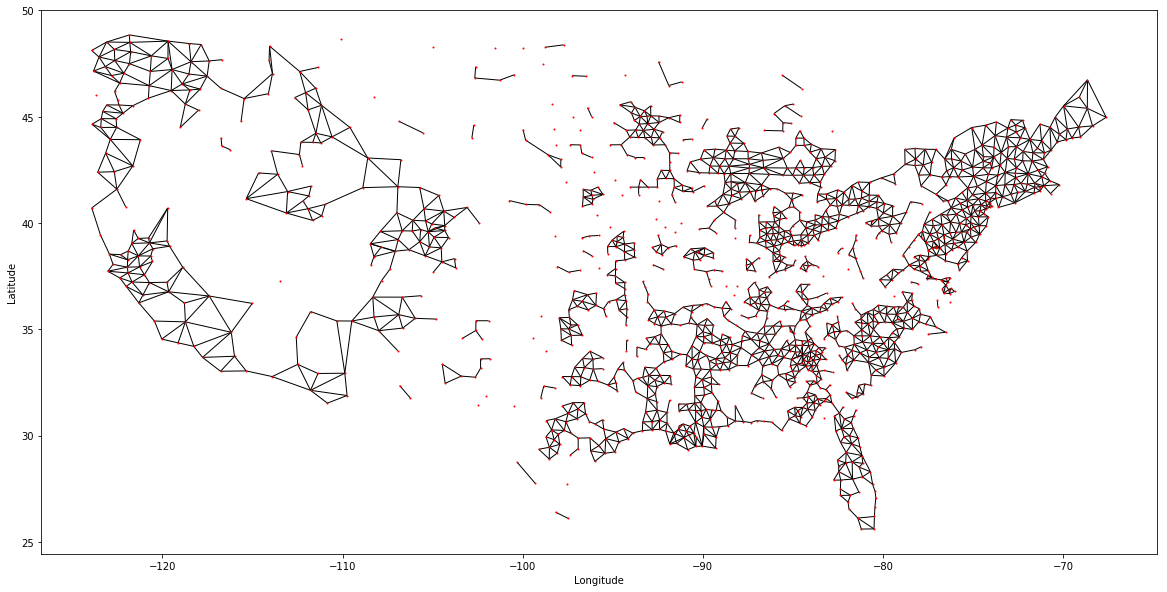

In [14]:
plt.figure(figsize=(20,10))
nx.drawing.nx_pylab.draw_networkx(
        G, 
        pos=location_dictionary,
        node_size=1,
        with_labels=False)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

## Failure Modes

Consider the above graph. Note that we had to throw out edges
that had a nodes that didn't have a reported geolocation...
Hence the missed county "edge" connections in the middle left of the US.
These counties might be where we fail or miss predictions, because of the data.

## Workarounds: 

### - Compute geolocations for all counties without a geolocation by computing the average geolocation of its neighbors (You can do it yourself)


In [15]:


# Could also attributes to each node ID 
# - https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html#adding-attributes-to-graphs-nodes-and-edges

In [24]:
# Now let's provide a size metric for our nodes based on our data
# Use some arbitrary days in March and see how the virus spreads
# Let's use confirmed case numbers
def plot_us_cases_with_date(dt):
    """
    dt: A string representing date of number of cases
        "3/10/2020" for example.
        
    https://networkx.github.io/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx
    """
    county_case_numbers = combined[dt].to_list()
    plt.figure(figsize=(20,10))
    nx.drawing.nx_pylab.draw_networkx(
            G, 
            pos=location_dictionary,
            node_size=county_case_numbers,
            with_labels=False)
    plt.xlabel("Longitude", fontsize=20)
    plt.ylabel("Latitude", fontsize=20)
    plt.title("US Confirmed Cases as of %s" % dt, fontsize=24)
    plt.show()

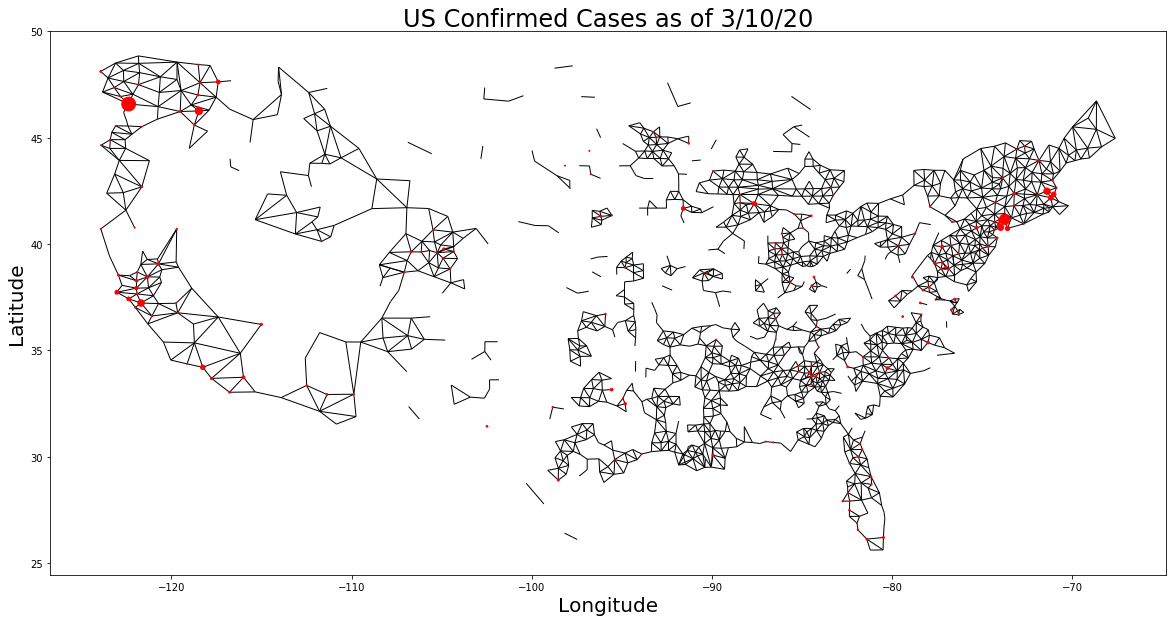

In [25]:
plot_us_cases_with_date("3/10/20")

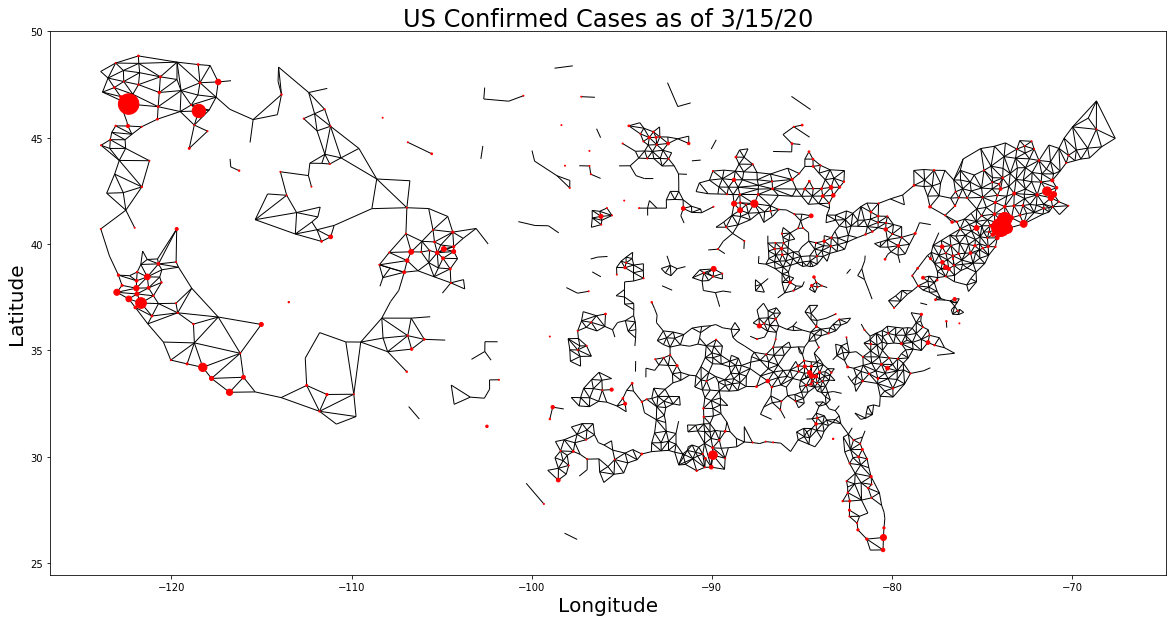

In [26]:
plot_us_cases_with_date("3/15/20")

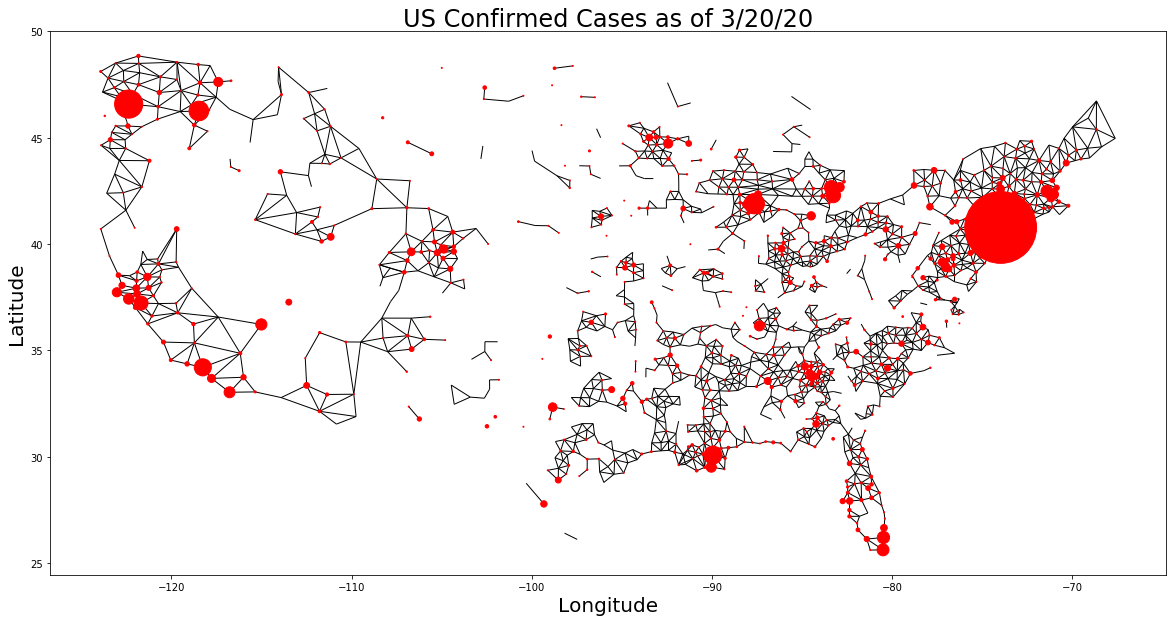

In [27]:
plot_us_cases_with_date("3/20/20")

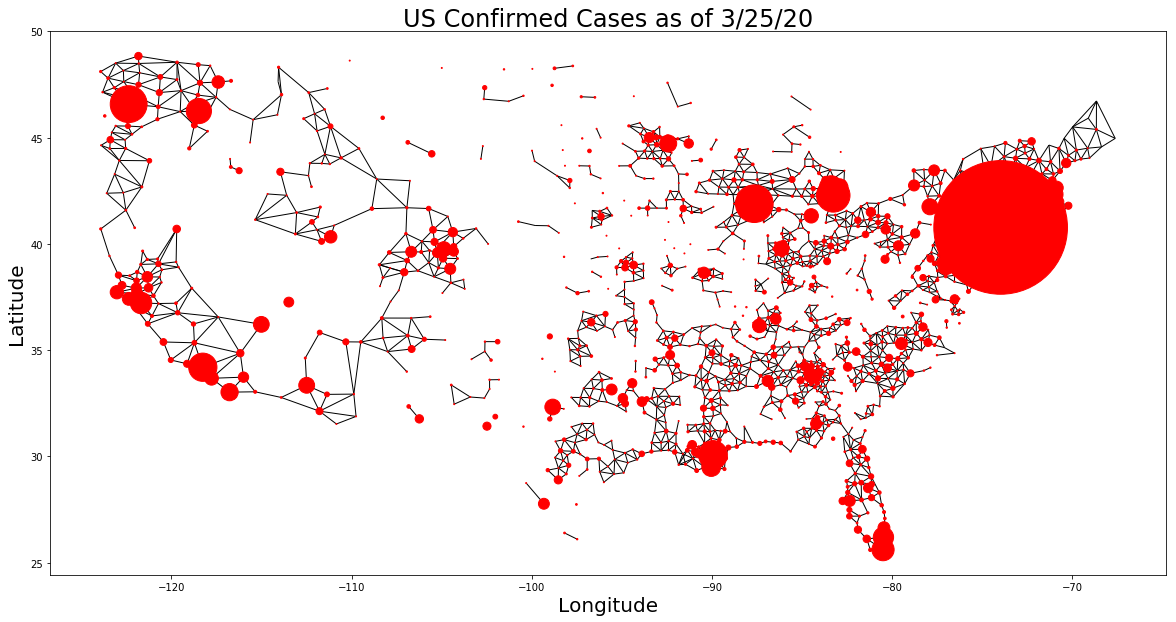

In [28]:
plot_us_cases_with_date("3/25/20")

In [21]:
combined.sort_values(by=["3/25/20"], ascending=False).head()

,countyFIPS,clon00,clat00,clon10,clat10,pclon00,pclat00,pclon10,pclat10,County Name,...,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20
1861,36061,-73.973533,40.769656,-73.970174,40.776557,-73.964923,40.780432,-73.966303,40.777958,New York City,...,463,814,2009,3954,5151,8115,9654,12339,14776,17856
1890,36119,-73.794013,41.057167,-73.745912,41.152770,-73.805386,41.039278,-73.804532,41.040536,Westchester County,...,220,380,538,798,1091,1385,1873,2894,3891,4691
1860,36059,-73.602538,40.715949,-73.589384,40.729687,-73.601185,40.715749,-73.602242,40.716587,Nassau County,...,109,131,183,372,754,1234,1900,2442,2869,3285
1882,36103,-73.026232,40.833314,-72.692218,40.943554,-73.119032,40.820237,-73.113775,40.821924,Suffolk County,...,63,84,116,178,371,662,1034,1458,1880,2260
613,17031,-87.767817,41.837649,-87.645455,41.894294,-87.752517,41.864508,-87.757714,41.865937,Cook County,...,77,107,178,278,411,548,805,922,1194,1418
